<a href="https://colab.research.google.com/github/Sedighe-Raeisi/Tumor-Segmentation-with-MRCNN/blob/main/Tumor_Segmentation_MaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Necessary Installations

In [ ]:
!pip install pycocotools

This downgrade is necessary for using mrcnn

In [ ]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 4.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [ ]:
!pip install keras==2.2.5
!pip install tensorflow==1.15.2

     |████████████████████████████████| 336 kB 4.4 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.2.5 which is incompatible.
     |████████████████████████████████| 110.5 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 30.7 MB/s 
     |████████████████████████████████| 503 kB 47.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=d2fa59e4bac9b8739767fc06a264f9f95c5453c7ad48b1e8a22088d218957dde
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/

#Operate these only, one times:

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 14.34 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [ ]:
!cp /content/Mask_RCNN/mrcnn -r /content

In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt


I uploaded my dataset to my drive for later uses

In [ ]:
# !cp /content/Dataset.zip -r /content/drive/MyDrive/MachineLearing/Seg_MRCNN

In [ ]:
!cp /content/Dataset.zip -r /content/drive/MyDrive/MachineLearning/seg_MRCNN

cp: cannot stat '/content/Dataset.zip': No such file or directory


In [ ]:
!cp /content/drive/MyDrive/MachineLearning/seg_MRCNN/Dataset.zip -r /content

In [ ]:
!unzip /content/Dataset.zip -d /content

In [ ]:
# !mkdir /content/Tumor

In [ ]:
ROOT_DIR='/content/'

In [ ]:
sys.path.append(ROOT_DIR)

In [ ]:
from mrcnn.config import Config

In [ ]:
from mrcnn import model as modellib, utils

Using TensorFlow backend.


now downloading the pretrained weights on coco dataset: https://github.com/matterport/Mask_RCNN/releases

In [ ]:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [ ]:
# !cp /content/mask_rcnn_coco.h5 -r /content/drive/MyDrive/MachineLearing/Seg_MRCNN

In [ ]:
!cp /content/drive/MyDrive/MachineLearing/Seg_MRCNN/mask_rcnn_coco.h5 -r /content

cp: cannot stat '/content/drive/MyDrive/MachineLearing/Seg_MRCNN/mask_rcnn_coco.h5': No such file or directory


In [ ]:
COCO_WEIGHTS_PATH=os.path.join(ROOT_DIR,'mask_rcnn_coco.h5')

In [ ]:
!mkdir /content/logs

In [ ]:
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + phone,laptop and mobile

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + phone,laptop and mobile   ########<<<<------HERE

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

############################################################
#  Dataset
############################################################

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "Tumor")                           ########<<<<------HERE
        

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir,'via_project.json'))) ########<<<<------HERE
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        # annotations = [a for a in annotations if a['regions']]
        annotations = [a for a in annotations if 'regions' in a]
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            #name_dict = {"laptop": 1,"tab": 2,"phone": 3}
            name_dict = {"Tumor": 1} #,"xyz": 3}                               ########<<<<------HERE
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


#1st Train:

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/Dataset", "train")                       ########<<<<------HERE
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/Dataset", "val")                            ########<<<<------HERE
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=5,
                layers='heads')
				
				
				
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

			







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
train(model)

In [ ]:
!cp /content/logs/object20220216T0604/mask_rcnn_object_0005.h3 -r /content/drive/MyDrive/MachineLearing/Seg_MRCNN/weight_1st_3

#I train the model for some more epochs:
That's because the google collab would be disconnected after 5 epochs. After, 5 epochs, I save weights and restart training from these weights to prevent losing all trained weights.
I used the model after 7 epochs for prediction on sample images. I could train for more epochs if the Google Collab didn't disconnect.

In [ ]:
# !cp /content/drive/MyDrive/MachineLearing/Seg_MRCNN/weight_1st_3 -r /content

In [ ]:
!cp /content/drive/MyDrive/MachineLearning/seg_MRCNN/mask_rcnn_object_0000.h5 -r /content

In [ ]:
weights_path=os.path.join('/content/','mask_rcnn_object_0001.h5')

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/Dataset", "train")                       ########<<<<------HERE
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/Dataset", "val")                            ########<<<<------HERE
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=1,
                layers='heads')
				
				
				
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)

# weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

			







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
... done downloading pretrained model!


In [ ]:
model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
import shutil

In [ ]:
# !cp /content/logs/object20220217T0715/mask_rcnn_object_0001.h5 -r /content/drive/MyDrive/MachineLearing/Seg_MRCNN/2nd_train

In [ ]:
os.mkdir('/content/logs')

In [ ]:
os.listdir('/content/logs')

[]

In [ ]:
weights_path='/content/drive/MyDrive/MachineLearning/seg_MRCNN/2nd_train/mask_rcnn_object_0001.h5'
i=0
def train(model):
  """Train the model."""
  # Training dataset.
  dataset_train = CustomDataset()
  dataset_train.load_custom("/content/Dataset", "train")                       ########<<<<------HERE
  dataset_train.prepare()

  # Validation dataset
  dataset_val = CustomDataset()
  dataset_val.load_custom("/content/Dataset", "val")                            ########<<<<------HERE
  dataset_val.prepare()

  # *** This training schedule is an example. Update to your needs ***
  # Since we're using a very small dataset, and starting from
  # COCO trained weights, we don't need to train too long. Also,
  # no need to train all layers, just the heads should do it.
  print("Training network heads")
  model.train(dataset_train, dataset_val,
              learning_rate=config.LEARNING_RATE,
              epochs=1,
              layers='heads')
      
      
        
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)

# weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

      
model.load_weights(weights_path, by_name=True, exclude=[
          "mrcnn_class_logits", "mrcnn_bbox_fc",
          "mrcnn_bbox", "mrcnn_mask"])
train(model)
log_folder=os.listdir('/content/logs')[0]
shutil.copy('/content/logs/'+log_folder+f'/mask_rcnn_object_000{i+1}.h5','/content/drive/MyDrive/MachineLearning/seg_MRCNN/2nd_train')
weights_path='/content/logs/'+log_folder+f'/mask_rcnn_object_000{i+1}.h5'



In [32]:
!cp /content/logs/object20220217T1055/mask_rcnn_object_0001.h5 -r /content/drive/MyDrive/MachineLearning/seg_MRCNN/2nd_train/8

#Testing model for some images:

In [ ]:
!cp /content/drive/MyDrive/MachineLearing/Seg_MRCNN/weight_1st_3/mask_rcnn_object_0005.h5 -r /content

In [57]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = "/content/"                 #<<<<<<<<-----------CHANGE HERE

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH ='/content/drive/MyDrive/MachineLearning/seg_MRCNN/2nd_train/8/mask_rcnn_object_0001.h5'                              #<<<<<<<<-----------CHANGE HERE

In [58]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # Background + phone,laptop and mobile    #<<<<<<<<-----------CHANGE HERE

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/Dataset/")      #<<<<<<<<-----------CHANGE HERE
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()

In [60]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "Tumor")      #<<<<<<<<-----------CHANGE HERE
        

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations1 = json.load(open(os.path.join(dataset_dir,'via_project.json')))  #<<<<<<<<-----------CHANGE HERE

        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Tumor": 1}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):

        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [ ]:
TEST_MODE = "inference"
ROOT_DIR = "/content/"    #<<<<<<<<-----------CHANGE HERE

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "/content/Dataset/"   #<<<<<<<<-----------CHANGE HERE
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

In [63]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [79]:
# Load COCO weights Or, load the last model you trained
weights_path = '/content/drive/MyDrive/MachineLearning/seg_MRCNN/2nd_train/7/mask_rcnn_object_0001.h5' #WEIGHTS_PATH  #<<<<<<<<-----------CHANGE HERE
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/MyDrive/MachineLearning/seg_MRCNN/2nd_train/7/mask_rcnn_object_0001.h5


In [80]:
#Now, we are ready for testing our model on any image.

#RUN DETECTION
image_id = random.choice(dataset.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

image id is : 25
image ID: object.Y255.JPG (25) /content/Dataset/val/Y255.JPG
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  363.00000  max:  743.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8
1
Processing 1 images
image                    shape: (342, 273, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


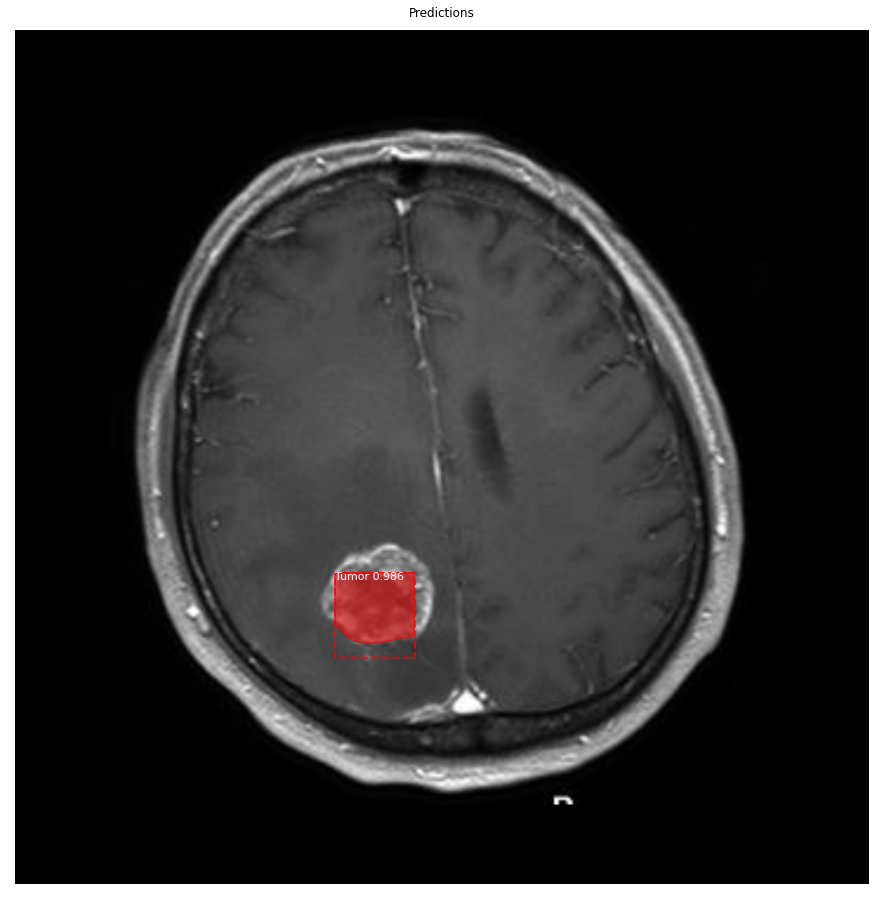

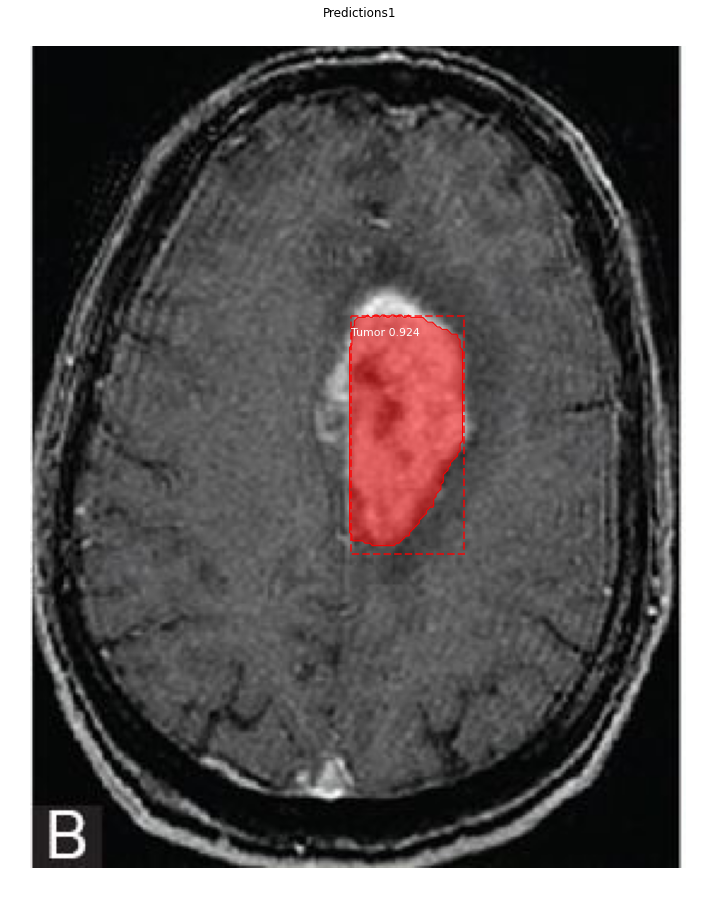

In [81]:
# Display results
x = get_ax(1)
r = results[0]
ax = plt.gca()
visualize.display_instances(image, 
                            r['rois'], 
                            r['masks'], 
                            r['class_ids'], dataset.class_names, 
                            r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
# This is for predicting images which are not present in dataset
path_to_new_image = '/content/Y192.JPG'     #<<<<<<<<-----------CHANGE HERE
image1 = mpimg.imread(path_to_new_image)

# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

2nd Method for using model on custome image:


In [66]:
class_names=['BG','Tumor']

Processing 1 images
image                    shape: (338, 283, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


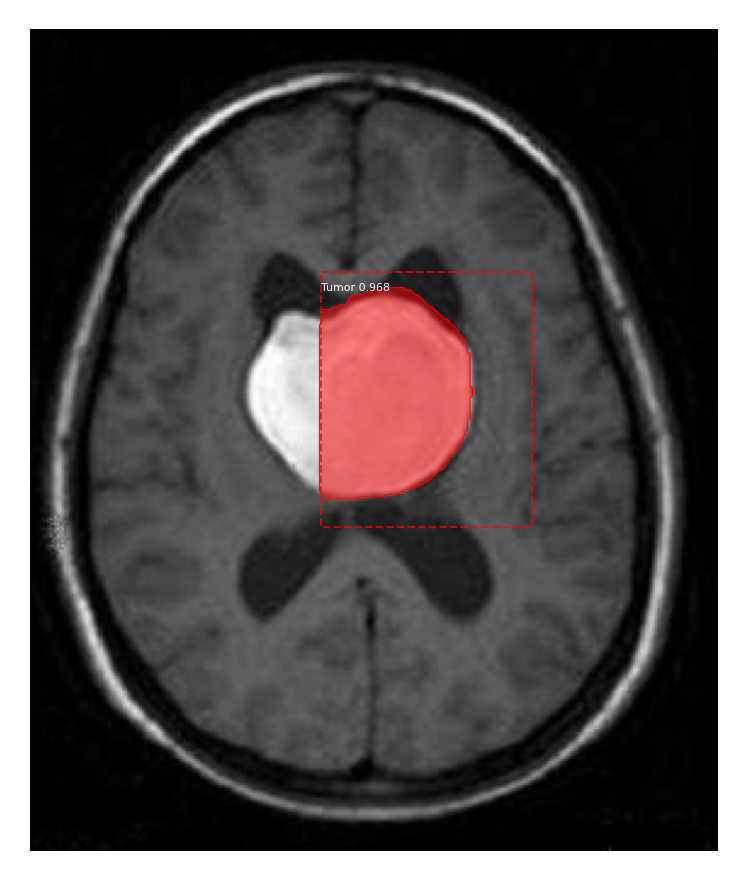

In [83]:
image = skimage.io.imread('/content/Y253.JPG')#mine_Sedighe
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])